In [121]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

from utils import plot_images_full, generate_matrix, batch_dirichlet, get_similarities, plot_similarities, get_differences, plot_differences, get_images, plot_images

#from models.vit import ViT, SimpleViT, SimpleViTI, SimpleViTFT

from sklearn.metrics.pairwise import cosine_similarity

In [122]:
def is_pos_def(M):
    return np.all(np.linalg.eigvals(M+M.T) > 0)

In [125]:
def R(theta,d): 
    theta = np.radians(theta)
    a = np.ones((d,d))
    K = np.cross(a,(np.eye(a.shape[0]) * -1))
    print(K)
    R = np.eye(d) + np.sin(theta)*K + (1-np.cos(theta))*(K**2)
    return R

In [126]:
R(45,3)

[[ 0. -1.  1.]
 [ 1.  0. -1.]
 [-1.  1.  0.]]


array([[ 1.        , -0.41421356,  1.        ],
       [ 1.        ,  1.        , -0.41421356],
       [-0.41421356,  1.        ,  1.        ]])

In [74]:
def image_to_graph(image, a_type="grid"):
    n = image.size(2)  # dimension of the grid
    A = torch.zeros((n*n, n*n))  # initialize adjacency matrix
    X = image.flatten(2).transpose(1,2)
    X = X.double()
    
    if a_type == "attention":
        d = X.size(-1)
        K = X@torch.normal(0,1,(d,d)).double()
        V = X@torch.normal(0,1,(d,d)).double()
        #A = torch.nn.functional.softmax(generate_matrix(n*n,1),-1)
        A = torch.nn.functional.softmax(torch.bmm(K,K.transpose(-2,-1)),-1).squeeze()
        A = A.double()
        return X, A
    
    if a_type == "identity":
        A = torch.eye(n*n)
        A = A.double()
        return X, A
    
    
    if a_type == "grid":
        for i in range(n):
            for j in range(n):
                idx = i * n + j  # index of current pixel
                if i > 0:
                    # connect to top neighbor
                    A[idx, idx - n] = 1
                if i < n - 1:
                    # connect to bottom neighbor
                    A[idx, idx + n] = 1
                if j > 0:
                    # connect to left neighbor
                    A[idx, idx - 1] = 1
                if j < n - 1:
                    # connect to right neighbor
                    A[idx, idx + 1] = 1
    elif a_type == "distance":
        for i in range(n):
            for j in range(n):
                idx1 = i * n + j  # index of current pixel
                for k in range(n):
                    for l in range(n):
                        idx2 = k * n + l  # index of current pixel
                        distance = (i-k)**2 + (j-l)**2
                        A[idx1,idx2] = distance
    elif a_type == "dot":
        for i in range(n):
            for j in range(n):
                idx1 = i * n + j  # index of current pixel
                for k in range(n):
                    for l in range(n):
                        idx2 = k * n + l  # index of current pixel
                        distance = (image[:,:,i,j].T.squeeze()@image[:,:,k,l].squeeze()).mean()
                        A[idx1,idx2] = distance
    elif a_type == "nonlocal":
        for i in range(n):
            for j in range(n):
                idx1 = i * n + j  # index of current pixel
                for k in range(n):
                    for l in range(n):
                        idx2 = k * n + l  # index of current pixel
                        distance = ((image[:,:,i,j].squeeze() - image[:,:,k,l].squeeze())**2).mean()
                        A[idx1,idx2] = torch.exp(distance)

    elif a_type == "full":
        A = torch.ones((n*n,n*n)) - torch.eye(n*n)
    elif a_type == "random":
        A = torch.normal(0,1,(n*n,n*n))
        A = 0.5*(A+A.T)
        A = (A>0).int()
    else: print("wrong type")
    
    A = A/A.sum(0)
    A = A.double()
                
    return X, A

In [75]:
batch_size = 1
size = 32
patch_size = 1
depth = 128
dim = 3
device = 'cpu'
data_path = './data/'

In [76]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root=data_path, train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=data_path, train=False,
                                       download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [112]:
def generate_matrix(dim,sign=1):
    Wp = torch.normal(0,0.1,(dim,dim))
    W0 = 0.5*(Wp+Wp.T)
    W = sign* W0@W0.T
    return W.double()

def diffusion_step(F,A,W,tau=1):
    return tau*torch.einsum('kv,nvd -> nkd',A,torch.einsum('nvd,dk -> nvk',F,W)) + F

def diffusion_stepFT(F,A,W,tau=0.5):
    return tau*torch.einsum('kv,nvd -> nkd',A,torch.einsum('nvd,dk -> nvk',F,W)) + (1-tau)*F

def diffusion_stepI(F,A,W,tau=1):
    return tau*torch.einsum('kv,nvd -> nkd',A-torch.eye(A.shape[0]),torch.einsum('nvd,dk -> nvk',F,W)) + F

def diffusion_stepIFT(F,A,W,tau=0.5):
    return tau*torch.einsum('kv,nvd -> nkd',A-torch.eye(A.shape[0]),torch.einsum('nvd,dk -> nvk',F,W)) + (1-tau)*F

def diffusion_stepR(F,A,W,tau=0.5):
    theta=25
    s = F.shape
    vF = F.flatten(1)
    return torch.einsum('kd,ndv -> nkv',torch.from_numpy(R(theta,vF.shape[-1])),vF).reshape(s)

In [118]:
R(25,5)

ValueError: incompatible dimensions for cross product
(dimension must be 2 or 3)

In [113]:
def diffusion_stepTV(F,A,W,tau=1):
    S = torch.sign(-torch.einsum('kv,nvd -> nkd',A,torch.einsum('nvd,dk -> nvk',F,W)))
    return tau*(A.T@S@W.T) + F

def diffusion_stepTVL2(F,A,W,tau=0.5):
    S = torch.sign(-torch.einsum('kv,nvd -> nkd',A,torch.einsum('nvd,dk -> nvk',F,W)))
    return tau*(A.T@S@W.T) + (1-tau)*F

In [114]:
image = next(iter(val_loader))[0].to(device)

X0,_ = image_to_graph(image,"identity")

As = [image_to_graph(image,"grid")[1] for _ in range(depth)]

Ws = [generate_matrix(dim,-1).double() for _ in range(depth)]
#W = torch.eye(dim)
#W = scipy.special.softmax(np.random.normal(0,0.1,(dim,dim)), axis=1)/dim
#W = scipy.special.softmax(generate_matrix(dim,-1), axis=1)/dim


In [115]:
rodriguesRotation(X0.flatten(),30)

ValueError: incompatible dimensions for cross product
(dimension must be 2 or 3)

In [ ]:
print(np.linalg.eig(Ws[0])[0])
cpos,cneg=0,0
for eig in np.linalg.eig(As[0])[0]:
    if eig>=0:
        cpos+=1
    else:
        cneg+=1
print(f"A has {cpos} positive eigenvalues and {cneg} negative eigenvalues")

In [ ]:
#one=torch.kron(Ws[0],As[0])
#Q=one+torch.eye(one.size(-1))
#print(min(torch.real(x) for x in torch.linalg.eig(Q)[0]))
#is_pos_def((Q.T@Q-torch.eye(Q.size(-1))).cpu().detach().numpy())

In [ ]:
As = [As[0]]*depth
Ws = [Ws[0]]*depth

In [ ]:
plt.imshow(As[0])

In [ ]:
plt.imshow(As[0][0,:].reshape(32,32))

In [ ]:
model_bases = {
    'A':diffusion_step,
    'I':diffusion_stepI,
    'FT':diffusion_stepFT,
    'IFT':diffusion_stepIFT,
    'TV': diffusion_stepTV,
    'TVL2': diffusion_stepTVL2,
    'R': diffusion_stepR
}

def get_output(x0,method):
    outputs = [x0]
    
    for A,W in zip(As,Ws):
        #outputs.append(outputs[-1]/np.linalg.norm(outputs[-1],axis=1))
        outputs.append(model_bases[method](outputs[-1],A,W))
            
    return outputs

## $\mathbf{F}(t+1) = \tau \mathbf{A}(\mathbf{F}(t))\mathbf{F}(t)\mathbf{W}(t) + \mathbf{F}(t)$

In [116]:
outputs = get_output(X0,'R')

ValueError: incompatible dimensions for cross product
(dimension must be 2 or 3)

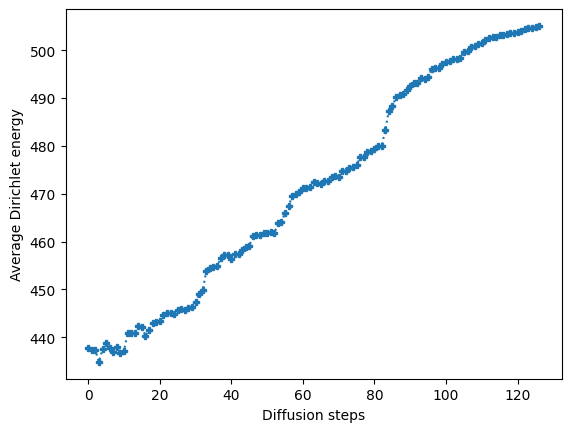

In [109]:
dirichlet_input = [x/(np.linalg.norm(x, ord='fro', axis=(-1,-2))) for x in outputs]
#dirichlet_input = [x for x in outputs]
similarities = get_similarities(dirichlet_input)
plot_similarities(similarities[2:])

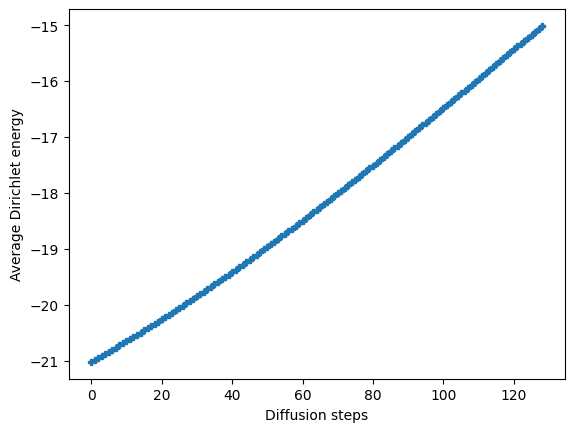

In [65]:
plot_similarities([-abs(x.sum(axis=(-1,-2)).mean()) for x in dirichlet_input])

In [66]:
similarities[-2],similarities[-1]

(451.37340911548284, 451.4342493534675)

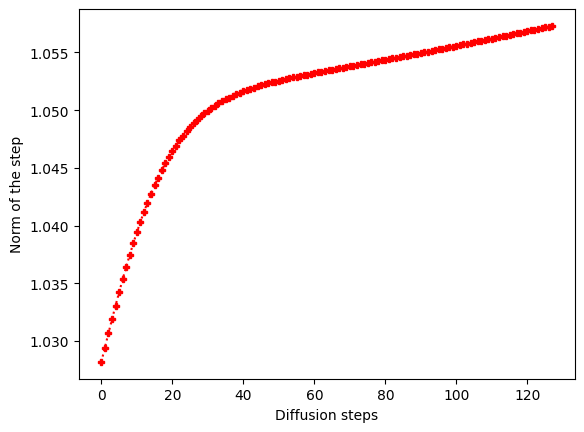

In [134]:
differences = get_differences(outputs)
plot_differences(differences)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


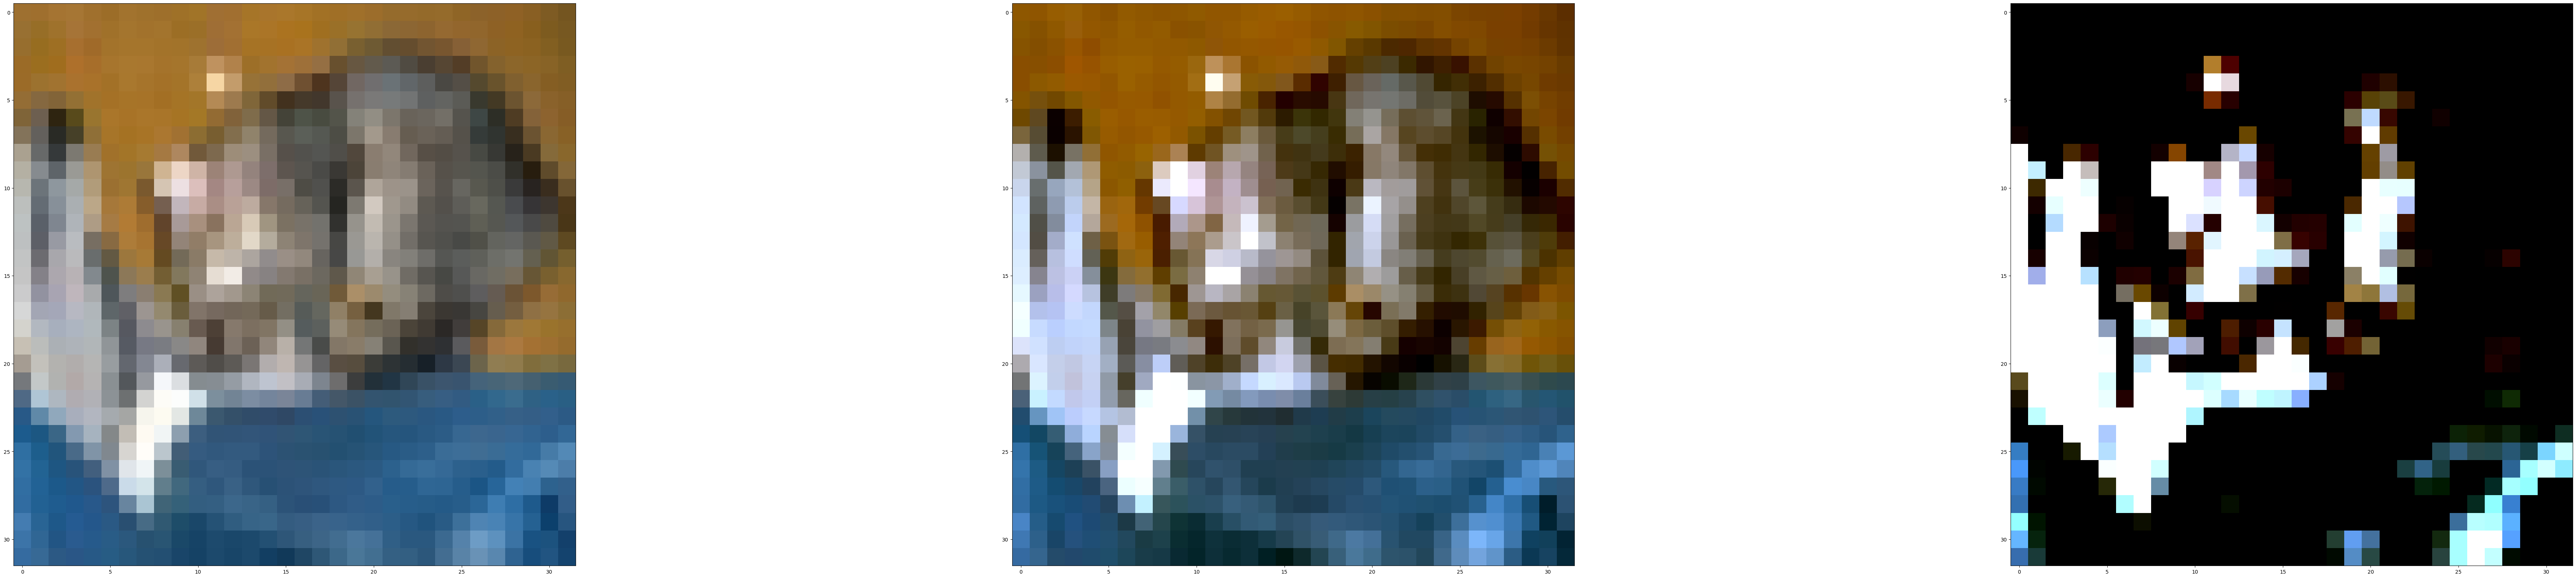

In [104]:
if patch_size == 1 and dim==3:
    images = get_images(outputs)
    plot_images_full([images[0],images[32],images[-1]])

## $\mathbf{F}(t+1) = \tau \bar{\mathbf{A}}(\mathbf{F}(t))\mathbf{F}(t)\mathbf{W}(t) + \mathbf{F}(t)$

In [19]:
outputs = get_output(X0,'I')

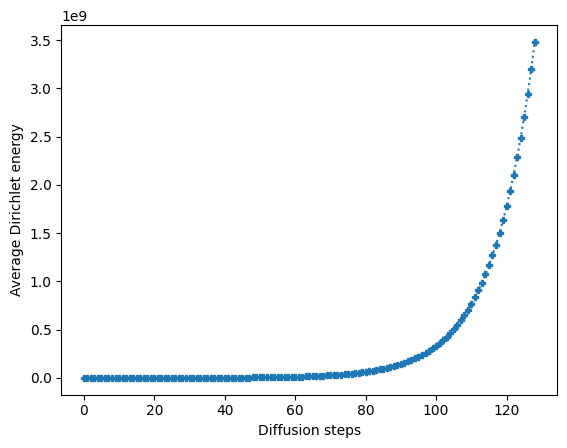

In [20]:
similarities = get_similarities(outputs)
plot_similarities(similarities)

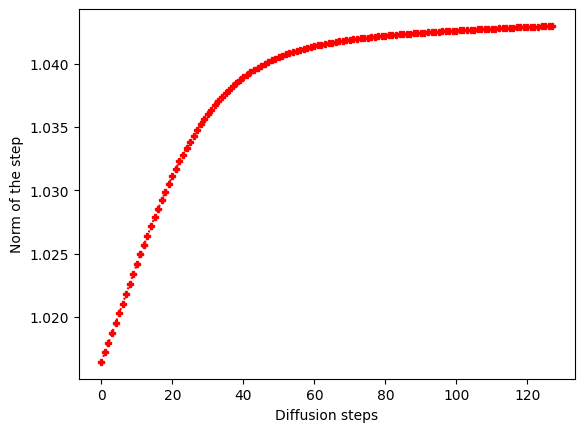

In [21]:
differences = get_differences(outputs)
plot_differences(differences)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


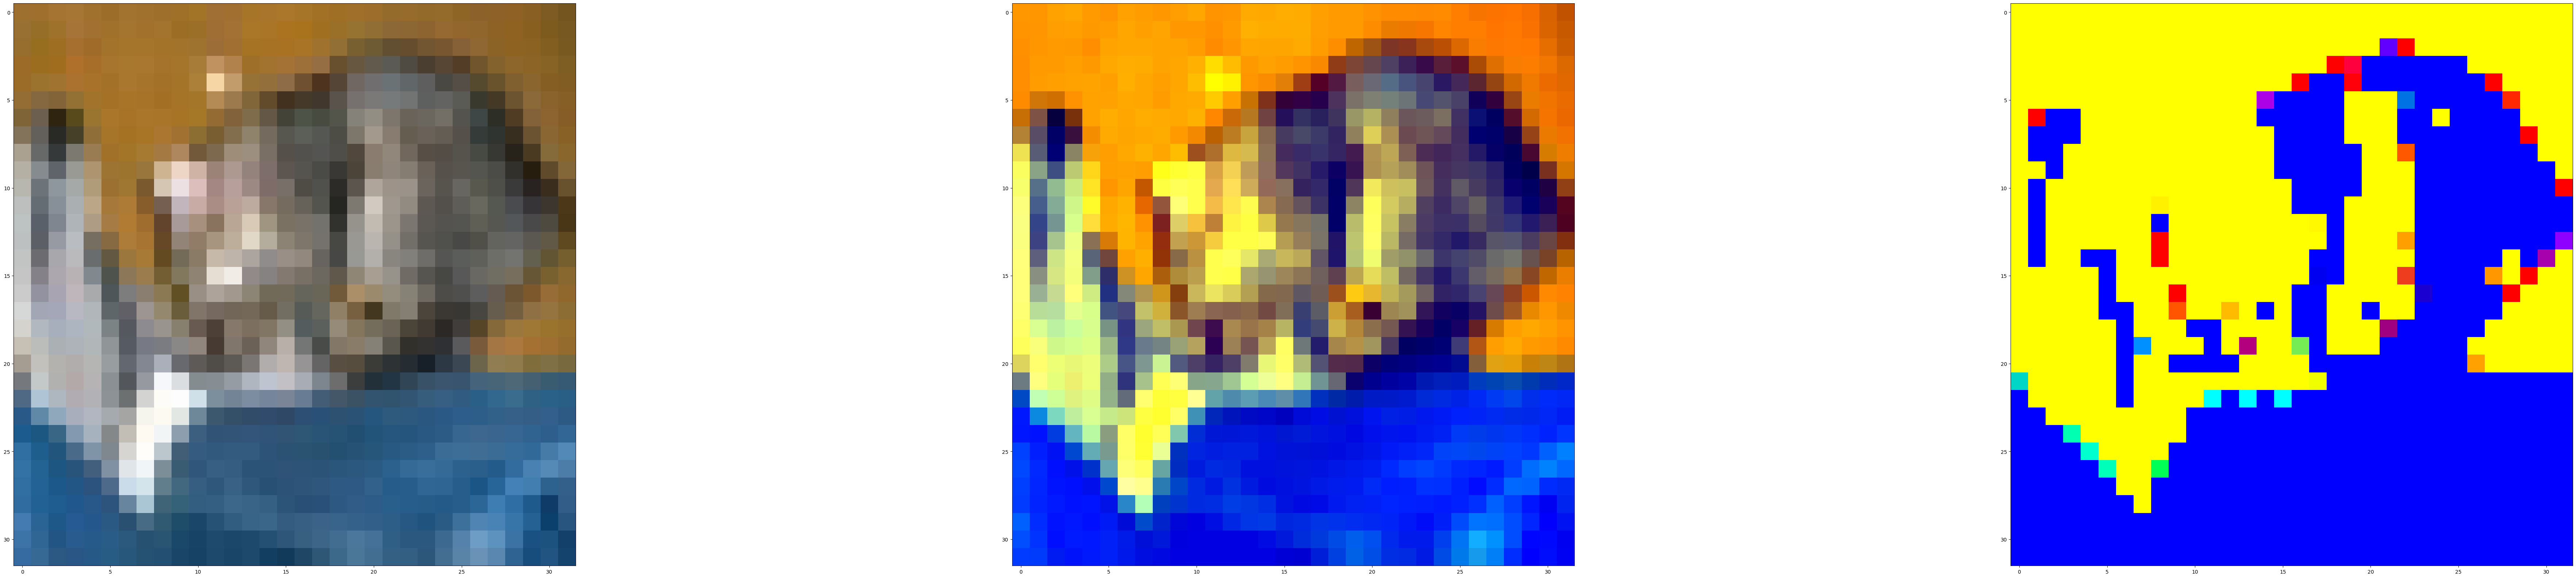

In [22]:
if patch_size == 1 and dim==3:
    images = get_images(outputs)
    plot_images_full([images[0],images[32],images[-1]])

## $\mathbf{F}(t+1) = \tau \mathbf{A}(\mathbf{F}(t))\mathbf{F}(t)\mathbf{W}(t) + (1 - \tau) \mathbf{F}(t)$

In [23]:
outputs = get_output(X0,'FT')

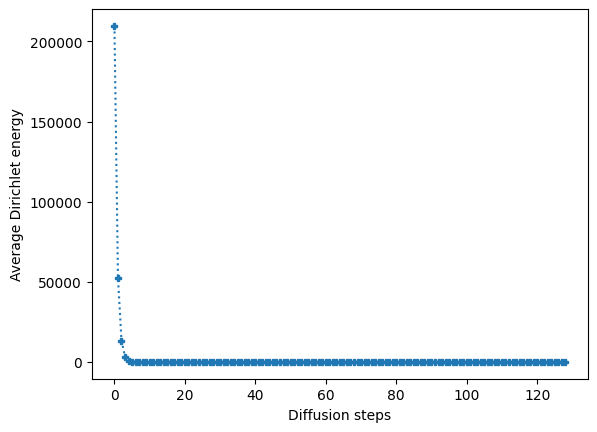

In [24]:
similarities = get_similarities(outputs)
plot_similarities(similarities)

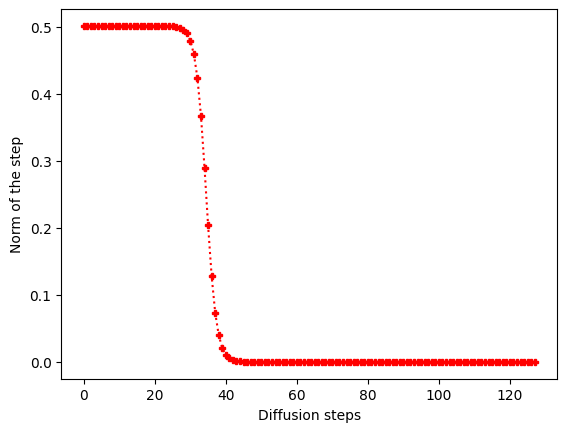

In [25]:
differences = get_differences(outputs)
plot_differences(differences)

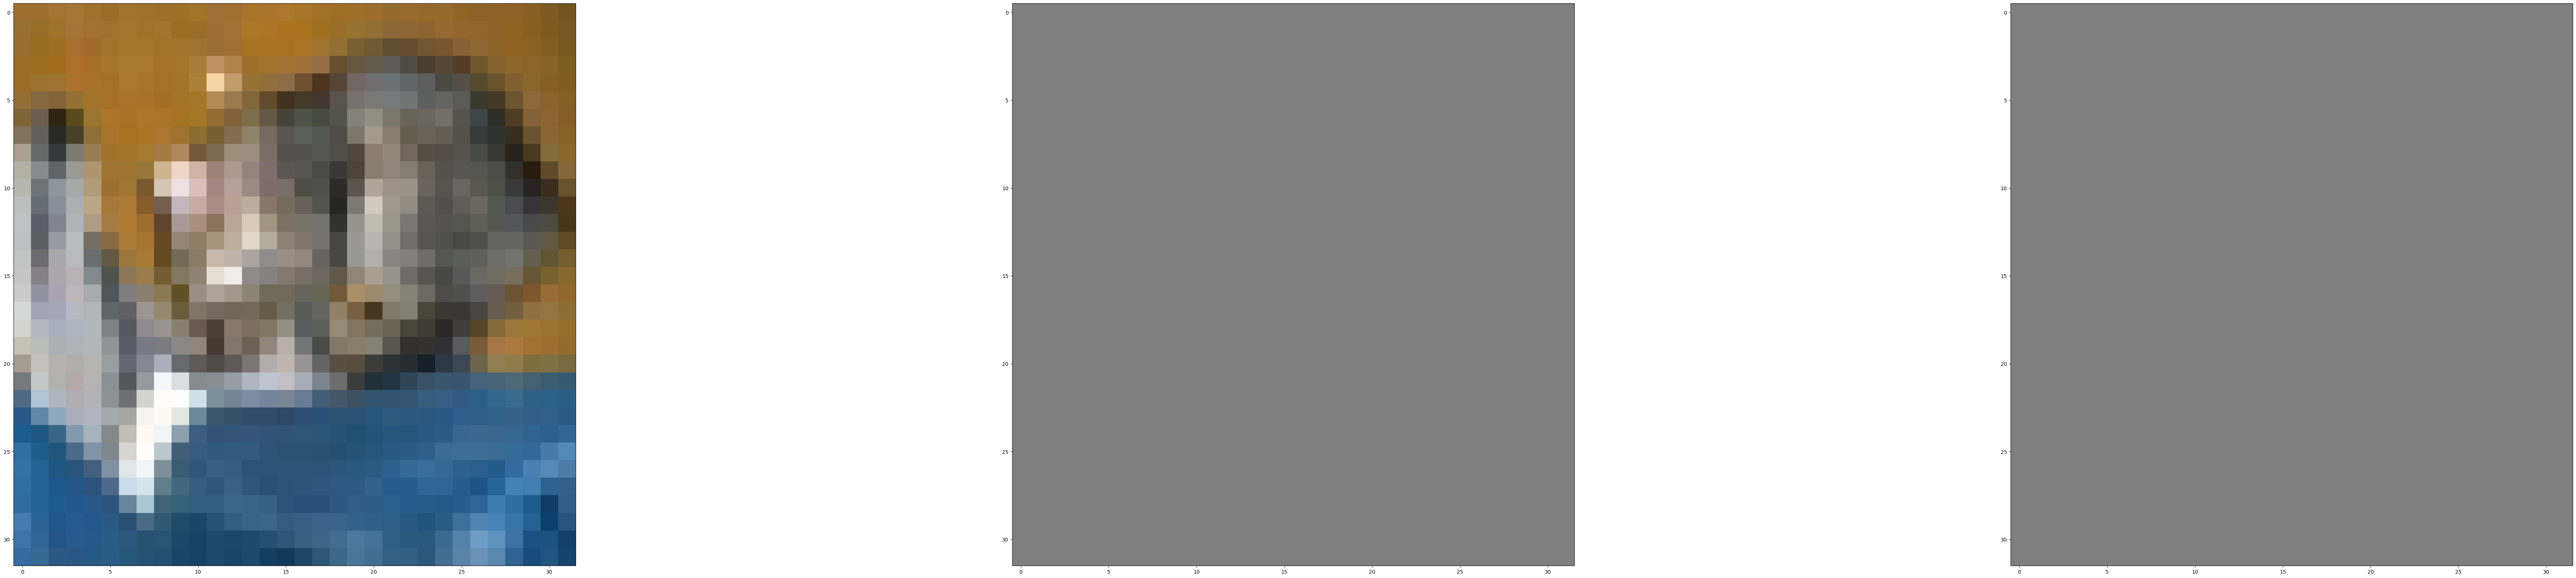

In [26]:
if patch_size == 1 and dim==3:
    images = get_images(outputs)
    plot_images_full([images[0],images[32],images[-1]])